In [1]:
import pandas as pd
import json
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
# sns.set(style='ticks', context='paper', font='CMU Sans Serif')
sns.set(style='ticks', context='paper')
from collections import defaultdict
import numpy as np
from util import plot_cdf,recover_data

In [2]:
def pn_distance(a, b, p):
    x = a.quantile(p)
    y = b.quantile(p)
    return (y - x) / x
    
def p99_distance(a, b):
    return pn_distance(a, b, 0.99)

P99_PERCENTILE_LIST = np.arange(1, 101, 1)

MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

In [3]:
N_FLOW_THRESHOLD=1
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4
N_FLOWS_PER_PATH=NR_INTEPOLATE*4
enable_sample_per_path=False
sample_per_path_str="_samp" if enable_sample_per_path else "_nosamp"
mlsys_dir_list=["mlsys-new_e426_s2"]
legend_list=['ns3-config','pmn-m',"mlsys"]
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./config_gen_{mlsys_dir}_p{NR_PATHS_SAMPLED}_l{NR_INTEPOLATE}_t{N_FLOW_THRESHOLD}{sample_per_path_str}.npz'
    # legend_list.append(mlsys_dir)
    if not os.path.exists(save_file):
        res_final=[]
        n_flows_in_f_list_final=[]
        # for worst_low_id in np.random.choice(66,50,replace=False):
        for worst_low_id in range(192):
            res_tmp=[]
            mix_dir = f'../data/{worst_low_id}'
            df_pmn_m = pd.read_csv(f'{mix_dir}/{legend_list[1]}/records.csv')
            
            n_freq_list=[]
            n_flows_in_f_list=[]
            n_flow_list=[]
            sizes=df_pmn_m['size']
            
            # mix_dir = f'/data2/lichenni/data_10m/{worst_low_id}'
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_freq=int(data[-1])
                    n_freq_list.append(n_freq)
                    for _ in range(n_freq):
                        n_flows_in_f_list.append(int(data[-3]))
                    
                    flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
                    size_list=[sizes[flowid] for flowid in flowid_list]
                    
                    n_links=len(data[0].split("|"))-1
                    tmp=np.digitize(size_list, bin_size_list)
                    # tmp=np.digitize(size_list, bin_size_dict[n_links])
                    # Count occurrences of each bin index
                    bin_counts = np.zeros(n_size_bucket_list_output)
                    for bin_idx in tmp:
                        bin_counts[bin_idx]+=1
                    n_flow_list.append(bin_counts)
                path_idx+=1
            assert sum(n_freq_list)==NR_PATHS_SAMPLED
            n_flow_list=np.array(n_flow_list)
            # print("n_flow_list: ",n_flow_list.shape)
            n_flow_list_sum=n_flow_list.sum(axis=0)
            # print("n_flow_list_sum: ",n_flow_list_sum)
            
            # print("n_flows_in_f: ",np.min(n_flows_in_f_list),np.median(n_flows_in_f_list),np.max(n_flows_in_f_list))
            n_flows_in_f_list_final.append(n_flows_in_f_list)
            
            df_ns3 = pd.read_csv(f'{mix_dir}/{legend_list[0]}/records.csv')
            df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
            
            sizes_ns3=np.array(df_ns3['size'])
            sizes_pmn=np.array(df_pmn_m['size'])
            bin_ns3=np.digitize(sizes_ns3, bin_size_list)
            bin_pmn=np.digitize(sizes_pmn, bin_size_list)
            bin_counts = np.bincount(bin_ns3)
            total_count = np.sum(bin_counts)
            bucket_ratios = bin_counts / total_count
            print("bucket_ratios: ",bucket_ratios)
            bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
            print("bucket_ratios_sampled: ",bucket_ratios_sampled)
            
            with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
                lines = file.readlines()
            lines = lines[1:]
            for line_idx,line in enumerate(lines):
                data=line.strip().split(",")
                data = [float(value) for value in data]
                assert len(data) == NR_INTEPOLATE
                n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
                
                if enable_sample_per_path:
                    prop_tmp=n_flow_list[line_idx//n_size_bucket_list_output]/np.sum(n_flow_list[line_idx//n_size_bucket_list_output])
                    num_tmp=int(N_FLOWS_PER_PATH*prop_tmp[line_idx%n_size_bucket_list_output])
                    data_sampled=np.random.choice(data,num_tmp,replace=True)
                    for _ in range(n_freq):
                        df_mlsys[line_idx%n_size_bucket_list_output].extend(data_sampled)
                else:
                    if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD:
                        for _ in range(n_freq):
                            df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
                
            df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]
            print(f"{worst_low_id}: {df_mlsys_shape}, {np.max(n_freq_list)}")
            
            sldn_mlsys_p99=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
            
            print("df_mlsys_p99: ",sldn_mlsys_p99)
            # sldn_mlsys_p99=np.sum(np.multiply(sldn_mlsys_p99.T, bucket_ratios).T,axis=0)
            df_mlsys_total=[]
            for i in range(len(df_mlsys)):
                # for _ in range(int(bucket_ratios[i]*100)):
                if enable_sample_per_path:
                    df_mlsys_total.extend(df_mlsys[i])
                else: 
                    n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
                    df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
            sldn_mlsys_p99=np.percentile(df_mlsys_total,99)

            sldn_ns3=df_ns3['slowdown']
            sldn_pmn_m=df_pmn_m['slowdown']
            sldn_ns3_p99=np.percentile(sldn_ns3,99)
            sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)
                
            print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," sldn_mlsys: ", sldn_mlsys_p99)

            res_tmp.append([sldn_ns3_p99,sldn_pmn_m_p99,sldn_mlsys_p99])

            # assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]
            # print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}, df_mlsys: {df_mlsys.shape[1]}")
            
            tmp_data=[]
            for i in range(len(bin_size_list)+1):
                tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
                tmp_sldn_pmn_m = np.extract(bin_pmn==i, sldn_pmn_m)
                tmp_sldn_mlsys=df_mlsys[i]
                
                sldn_ns3_p99=np.percentile(tmp_sldn_ns3,99)
                sldn_pmn_m_p99=np.percentile(tmp_sldn_pmn_m,99)
                df_mlsys_p99=np.percentile(tmp_sldn_mlsys,99)
                res_tmp.append([sldn_ns3_p99,sldn_pmn_m_p99,df_mlsys_p99])
                tmp_data.append(df_mlsys_p99)
            # print("df_mlsys: ",tmp_data)
            res_final.append(res_tmp)
        res_final = np.array(res_final)
        n_flows_in_f_list_final = np.array(n_flows_in_f_list_final)
        np.savez(save_file,res_final=res_final,n_flows_in_f_list_final=n_flows_in_f_list_final)
    else:
        data=np.load(save_file)
        res_final=data['res_final']
        n_flows_in_f_list_final=data['n_flows_in_f_list_final']
        print("res_final: ",res_final.shape)
    size_bucket_target=0
    if mlsys_dir_idx==0:
        res.append(res_final[:,size_bucket_target,0].transpose())
        res.append(res_final[:,size_bucket_target,1].transpose())
        res.append(res_final[:,size_bucket_target,2].transpose())
    else:
        res.append(res_final[:,size_bucket_target,-1].transpose())

res=np.array(res)

shard_seed=2
mix_file = f'../spec/all_config_{shard_seed}.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
mask=[]
cc_dict={
    "dctcp":"dctcp",
}
for mix in mixes:
    config_id=mix['id']
    cc=mix['cc']
    if not os.path.exists(f"/data1/lichenni/projects/flow_simulation/parsimon-eval/expts/fig_8/data/{config_id}/ns3-config/{shard_seed}/flows.txt") and not os.path.exists(f"/data1/lichenni/projects/flow_simulation/parsimon-eval/expts/fig_8/data/{config_id}/ns3-config/{shard_seed}/fct_topology_flows_{cc_dict[cc]}.txt"):
        mask.append(True)
    else:
        mask.append(False)
mask=np.array(mask)
res=res[:,mask]
n_flows_in_f_list_final=n_flows_in_f_list_final[mask]
print(res.shape)
n_flows_median_list=np.median(n_flows_in_f_list_final,axis=1)
# n_flows_median_list=n_flows_in_f_list_final
print("n_flows_median_list: ",n_flows_median_list.shape)

res_final:  (192, 5, 3)
(3, 192)
n_flows_median_list:  (192,)


median error:  [0.10304336 0.07759789]
90% error:  [0.41838858 0.2150806 ]
max error:  [1.45995096 0.334574  ]
(2, 192)
(192,)
(2, 192)


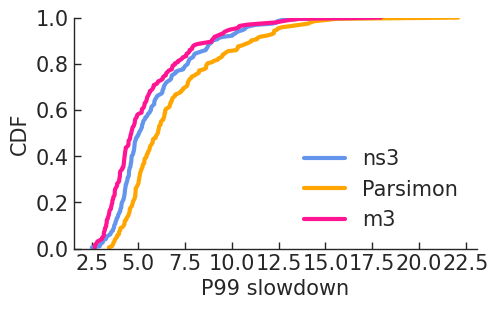

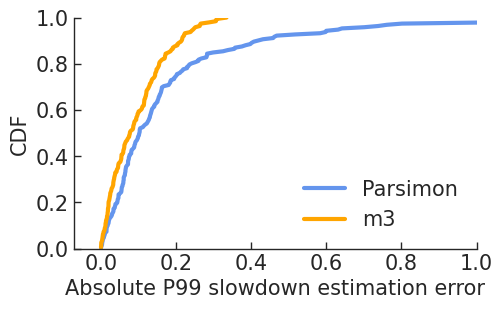

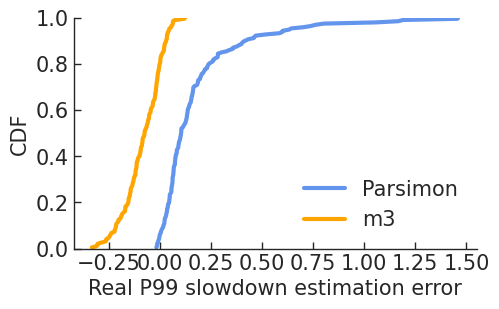

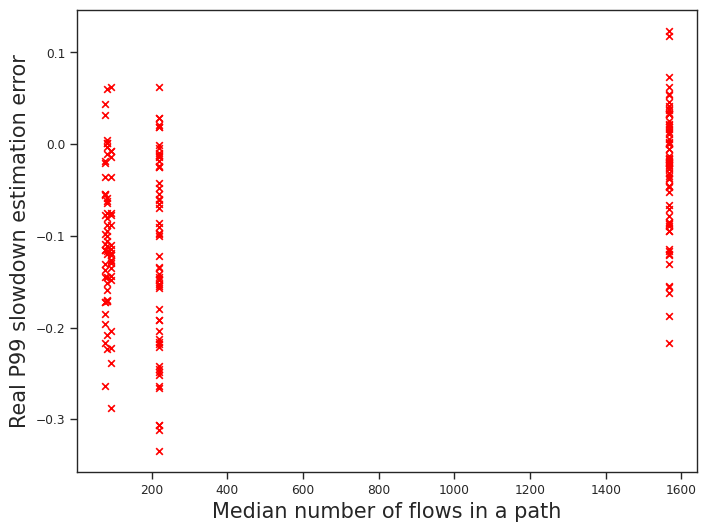

min: 5--0.3345740021439134, max: 43-0.12349177842709444


In [4]:
legend_list=['ns3',"Parsimon","m3"]
plot_cdf(res,None,legend_list,'P99 slowdown',legend_font=15,group_size=len(res),loc=4,rotate_xaxis=False)
error_abs=[]
for i in range(1,len(res)):
    tmp=np.abs(res[i]-res[0])/res[0]
    error_abs.append(tmp)
plot_cdf(error_abs,None,[legend_list[i] for i in range(1,len(legend_list))],'Absolute P99 slowdown estimation error',legend_font=15,group_size=len(error_abs),loc=4,rotate_xaxis=False,xlim=1)
print("median error: ", np.median(error_abs,axis=1))
print("90% error: ", np.percentile(error_abs,axis=1, q=90))
print("max error: ", np.max(error_abs,axis=1))

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_cdf(error_real,None,[legend_list[i] for i in range(1,len(legend_list))],'Real P99 slowdown estimation error',legend_font=15,group_size=len(error_real),loc=4,rotate_xaxis=False) 


figure, ax = plt.subplots(figsize=(8, 6))
_fontsize=15
error_real=np.array(error_real)
print(error_real.shape)
print(n_flows_median_list.shape)
new_data=np.array([error_real[-1],n_flows_median_list])
print(new_data.shape)
plt.scatter(n_flows_median_list,error_real[-1],marker='x',color='red')
plt.xlabel('Median number of flows in a path', fontsize=_fontsize)
plt.ylabel('Real P99 slowdown estimation error', fontsize=_fontsize)
plt.show()

min_idx=np.argmin(error_real[-1])
max_idx=np.argmax(error_real[-1])
print(f"min: {min_idx}-{error_real[-1][min_idx]}, max: {max_idx}-{error_real[-1][max_idx]}")


(2, 192)
median error:  [0.04587362000994884, 0.0755778932199039, 0.11821490790359869]
90% error:  [0.12084838575350458, 0.23446640150445852, 0.22203635089014193]
max error:  [0.21300743846896525, 0.3345740021439134, 0.2658907947698625]


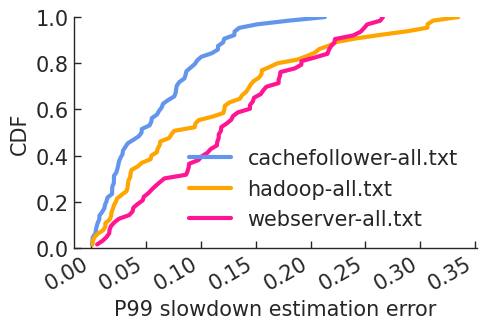

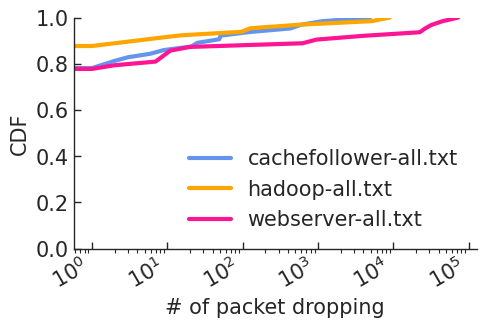

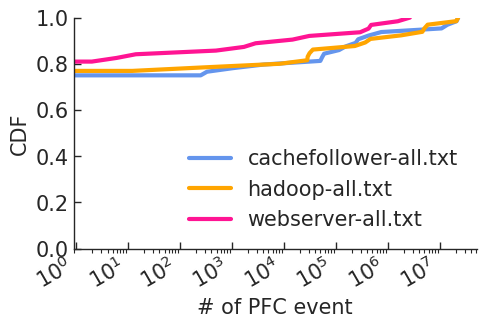

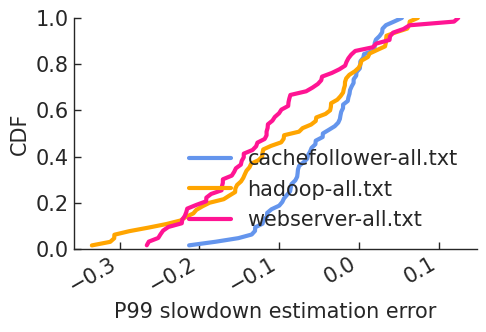

In [6]:
file2matrix = {
        '../../workload/spatials/cluster_a_2_16.json': 'Traffic Matrix A',
        '../../workload/spatials/cluster_b_2_16.json': 'Traffic Matrix B',
        '../../workload/spatials/cluster_c_2_16.json': 'Traffic Matrix C',
    }
file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }

mix_file = '../spec/all_config_2.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 

mlsys_dir_list=["mlsys-new_e426_s2_p500_l100_t1"]
# mlsys_dir_list=["mlsys_final_reprod_v1_p500_l100_t10"]
legend_list=['ns3',"mlsys"]
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./config_gen_{mlsys_dir}_nosamp.npz'
    data=np.load(save_file)
    tmp=data['res_final']
    n_flows_in_f_list_final=data['n_flows_in_f_list_final']
    val=tmp[:,0,:].transpose() 
    res.append(val[0])
    res.append(val[2])
res=np.array(res)
print(res.shape)
load_dict={
    0: "load: 0.25-0.35",
    1: "load: 0.35-0.45",
    2: "load: 0.45-0.55",
    3: "load: 0.55-0.65",
    4: "load: 0.65-0.75",
}
window_dict={
    0: "window: 5-10KB",
    1: "window: 10-15KB",
    2: "window: 15-20KB",
    3: "window: 20-25KB",
    4: "window: 25-30KB",
}
bfsz_dict={
    0: "bfsz: 200-300KB",
    1: "bfsz: 300-400KB",
    2: "bfsz: 400-500KB",
}
dctcp_k_dict={
    0: "k: 05-10KB",
    1: "k: 10-15KB",
    2: "k: 15-20KB",
}
traffic_dict=defaultdict(list)
n_events_dict=defaultdict(list)
for mix_id in range(len(mixes)):
    mix=mixes[mix_id]
    # if mix["cc"]!="dctcp": continue
    # if mix["cc"]!="timely": continue
    # if mix["cc"]!="hp": continue
    # val_key=file2matrix[mix['spatial']]
    # val_key=file2oversub[mix['cluster']]
    val_key=str(mix['size_dist'].split('/')[-1])
    # val_key=mix["cc"]
    # val_key=load_dict[(mix["max_load"]-0.25)//0.1]
    # val_key="enable_pfc: "+str(mix["enable_pfc"])
    # val_key=bfsz_dict[(mix["bfsz"]-20)//10]
    # val_key=window_dict[(mix["window"]-5000)//5000]
    # val_key=dctcp_k_dict[(mix["param_1"]-5)//5]
    # val_key=timely_tmin_dict[(mix["param_1"]-15)//5]
    # val_key=timely_tmax_dict[(mix["param_2"]-30)//10]
    # val_key=timely_tmin_dict[(mix["param_1"]-50)//25]+'_'+timely_tmax_dict[(mix["param_2"]-100)//50]
    # val_key=hp_ai_dict[(mix["param_2"]-10)//10]
    # val_key=hp_ita_dict[(mix["param_1"]-70)//10]
    # val_key=bfsz_dict[(mix["bfsz"]-15)//5]+"_"+window_dict[(mix["window"]-10000)//10000]
    
    # traffic_dict[traffic_mat+'_'+oversub].append(mix_id)
    lines_pkt_dropping=0
    with open(f"/data1/lichenni/projects/flow_simulation/parsimon-eval/expts/fig_8/data/{mix_id}/ns3-config/2/output.txt", 'r') as file:
        for line in file:
            if "Headroom full" in line:
                lines_pkt_dropping+=1
    lines_pfc=[1]
    with open(f"/data1/lichenni/projects/flow_simulation/parsimon-eval/expts/fig_8/data/{mix_id}/ns3-config/2/pfc_topology_flows_dctcp.txt", 'r') as file:
        lines_pfc = file.readlines()
        
    traffic_dict[val_key].append(mix_id)
    n_events_dict[val_key].append([lines_pkt_dropping,len(lines_pfc)])
traffic_dict = dict(sorted(traffic_dict.items()))
n_events_dict = dict(sorted(n_events_dict.items()))

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=True)
print("median error: ", [np.median(plot_data[i]) for i in range(len(plot_data))])
print("90% error: ", [np.percentile(plot_data[i],90) for i in range(len(plot_data))])
print("max error: ", [np.max(plot_data[i]) for i in range(len(plot_data))])

plot_data=[np.array([x[0] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of packet dropping',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=True,log_switch=True)

plot_data=[np.array([x[1] for x in n_events_dict[key]])  for key in n_events_dict]
plot_cdf(plot_data,None,list(n_events_dict.keys()),'# of PFC event',legend_font=15,group_size=len(n_events_dict),loc=4,rotate_xaxis=True,log_switch=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,None,list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=True)